## LAB EXERCISE - 3 IMDB MOVIE REVIEWS

In [ ]:
# Dependency parsing: Co-occurrence association rule mining 
import spacy
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

nlp = spacy.load("en_core_web_sm")

# Extract dependency-based co-occurrence pairs
def extract_pairs(text):
    doc = nlp(text)
    pairs = []
    for token in doc:
        if token.dep_ in ('amod', 'nsubj', 'dobj'):
            pairs.append(f"{token.head.lemma_}_{token.lemma_}")
    return pairs

# Apply on reviews
transactions = df['review'].dropna().apply(extract_pairs)
df_transactions = pd.DataFrame({'transactions': transactions})

# One-hot encoding for mlxtend
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(df_transactions['transactions']).transform(df_transactions['transactions'])
df_te = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori
frequent_itemsets = apriori(df_te, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

In [ ]:
# Unsupervised Machine Learning: BiLSTM, Aspect embedding generation;
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Use a subset for performance
sample_reviews = df['html_review'].sample(n=5000, random_state=42).values

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(sample_reviews)

# Aspect embeddings are the tf-idf vectors here
aspect_embeddings = tfidf_matrix.toarray()
print("Aspect Embedding Shape:", aspect_embeddings.shape)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

sample_reviews = df['html_review'].sample(n=5000, random_state=42).values

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sample_reviews)
sequences = tokenizer.texts_to_sequences(sample_reviews)
padded_sequences = pad_sequences(sequences, maxlen=200)

# Custom Dataset
class ReviewDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.tensor(sequences, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = self.sequences[idx]
        return x, x  # unsupervised, input == target

# DataLoader
train_dataset = ReviewDataset(padded_sequences)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# BiLSTM Autoencoder
class BiLSTMAutoencoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.decoder = nn.LSTM(2*hidden_dim, embedding_dim, batch_first=True)
        self.fc = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        x_embed = self.embedding(x)
        _, (h, _) = self.encoder(x_embed)
        h_cat = torch.cat((h[0], h[1]), dim=1).unsqueeze(1).repeat(1, x.size(1), 1)
        decoded, _ = self.decoder(h_cat)
        out = self.fc(decoded)
        return out

# Model setup
vocab_size = 10000
embedding_dim = 128
hidden_dim = 64
model = BiLSTMAutoencoder(vocab_size, embedding_dim, hidden_dim)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train loop (1 batch demo; remove break for full training)
model.train()
for batch_x, batch_y in train_loader:
    optimizer.zero_grad()
    output = model(batch_x)
    loss = criterion(output.view(-1, vocab_size), batch_y.view(-1))
    loss.backward()
    optimizer.step()
    break  # remove break to train longer
print("Trained 1 batch (demo). Loss:", loss.item())

Trained 1 batch (demo). Loss: 9.210609436035156


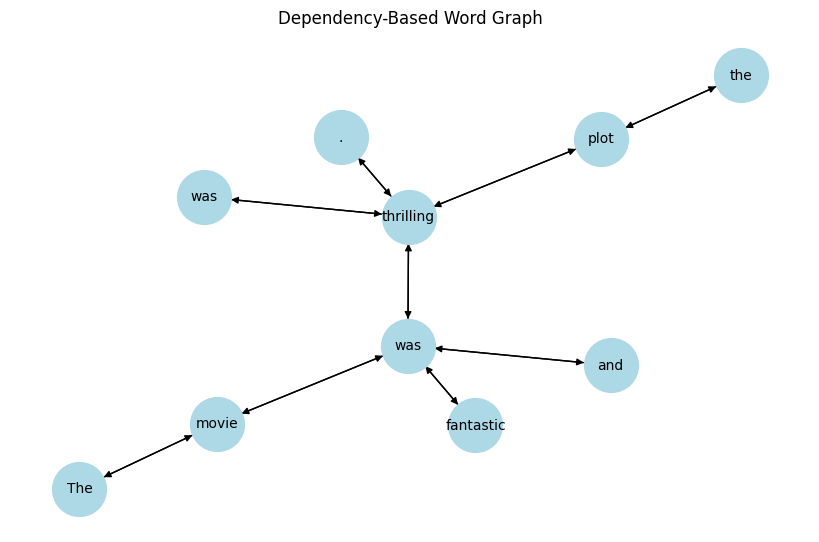

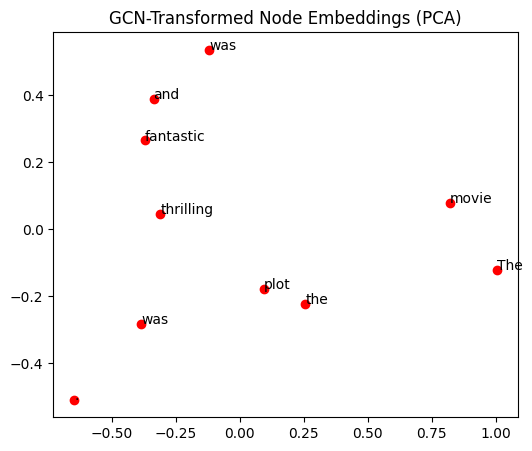

In [ ]:
# Supervised Machine Learning models: Hier-GCNN, Fine-tuned BERT
import torch
import torch.nn as nn
import spacy
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Load SpaCy model (word vectors included)
nlp = spacy.load("en_core_web_sm")

# ========== 1. Create Dependency Graph ========== #
def sentence_to_graph(sentence):
    doc = nlp(sentence)
    edge_index = []
    x = []

    for token in doc:
        x.append(torch.tensor(token.vector))  # node features from SpaCy vector
        if token.head.i != token.i:
            edge_index.append([token.i, token.head.i])
            edge_index.append([token.head.i, token.i])

    x = torch.stack(x)
    edge_index = torch.tensor(edge_index).t().contiguous()  # [2, num_edges]
    batch = torch.zeros(x.size(0), dtype=torch.long)  # single graph, all nodes in batch 0
    return Data(x=x, edge_index=edge_index, batch=batch), doc

# ========== 2. Define Simple Hier-GCNN Model ========== #
class HierGCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HierGCNN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gcn1(x, edge_index).relu()
        x = self.gcn2(x, edge_index).relu()
        return x  # node-level outputs

# ========== 3. Visualization: Graph Structure ========== #
def visualize_dependency_graph(doc, edge_index):
    G = nx.DiGraph()
    for i, token in enumerate(doc):
        G.add_node(i, label=token.text)
    for i, j in edge_index.t().tolist():
        G.add_edge(i, j)
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    plt.figure(figsize=(8, 5))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=1500, font_size=10)
    plt.title("Dependency-Based Word Graph")
    plt.show()

# ========== 4. Visualization: Embedding Space ========== #
def visualize_node_embeddings(x_out, doc):
    x_out = x_out.detach().numpy()
    x_reduced = PCA(n_components=2).fit_transform(x_out)
    plt.figure(figsize=(6, 5))
    plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c='red')
    for i, token in enumerate(doc):
        plt.annotate(token.text, (x_reduced[i, 0], x_reduced[i, 1]))
    plt.title("GCN-Transformed Node Embeddings (PCA)")
    plt.show()

# ========== 5. Run Everything ========== #
sentence = "The movie was fantastic and the plot was thrilling."
graph_data, doc = sentence_to_graph(sentence)

model = HierGCNN(input_dim=96, hidden_dim=64, output_dim=32)  # SpaCy en_core_web_sm = 96 dim
x_out = model(graph_data)

visualize_dependency_graph(doc, graph_data.edge_index)
visualize_node_embeddings(x_out, doc)
